We need:

- A function that for given $A$ and $y_0$ computes iid solutions $Y_1$ of the SDE $$\mathrm{d} Y^k = A^k_{i\gamma}Y^i \circ \mathrm{d}W^\gamma + B^k_iY^i \mathrm{d}t, \qquad Y_0 = y_0, $$ and averages them.
- A function that computes the same mean directly as the solution to an ODE by converting to Itô and taking expectations $$\mathbb E Y_1^k = \int \bigg(\frac 12 \sum_{\gamma = 1}^d A^k_{i \gamma} A^i_{j \gamma} \mathbb E Y_t^j + B^k_i \mathbb E Y^i \bigg)\mathrm{d} t $$
- A function that takes the cubature points and weights and computes the weak error, as the absolute difference of the above mean and the Euler solution of the cubature of degrees 3, 5, 7 on $m$ intervals.

In [65]:
import importlib
import jax
jax.config.update("jax_enable_x64", True)
from diffrax import *
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import utils_plots as ut

importlib.reload(ut)

<module 'utils_plots' from '/Users/emilioferrucci/Documents/MATH/PostDoc Oxford/cubature/utils_plots.py'>

In [72]:
e, d = 2, 3
sample_size = 100
key = jax.random.PRNGKey(981698)
key0AB = jax.random.split(key, 3)

y0 = jax.random.normal(key0AB[0], (e,))
y0 = y0 / jnp.linalg.norm(y0)
A = jax.random.normal(key0AB[1], (e, e, d))
A = A / jnp.linalg.norm(A)
B = jax.random.normal(key0AB[2], (e, e))
B = B / jnp.linalg.norm(B)
B = jnp.zeros((e,e))

ut.mean_ODE(y0, A, B) - ut.monte_carlo(sample_size, d, y0, A, B)

# mean_ODE works well, use that from now on
true_mean = ut.mean_ODE(y0, A, B)

One step cubature, return:

$$\Big[y_0 + \sum_{n = 1}^\mathrm{degree} C^{\otimes n} y_0 \pi_n \exp(\mathcal L_i) : i = 1,...,\mathrm{nopts} \Big]$$

where $C = (B | A)$ (drift in the zero-th coordinate).

In [8]:
# this just creates a list of jnp arrays of ones of the right dimension to check that the function above works
def one_cub_sim(degree, no_pts, d):
    return [jnp.ones((no_pts,) + (1 + d,) * (k)) for k in range(degree + 1)]

cub_size = 648
deg = 7
cub_sim = one_cub_sim(deg, cub_size, d)
w = jnp.ones(cub_size) / cub_size
ut.multistep_cubature(y0, A, B, cub_sim, w, 3)

Array([-587.96600262, 3981.14990923], dtype=float64)

In [69]:
import pickle

with open("degree_3.pkl", "rb") as f:
    cubature_3 = pickle.load(f)
    
with open("degree_5.pkl", "rb") as f:
    cubature_5 = pickle.load(f)

with open("degree_7.pkl", "rb") as f:
    cubature_7 = pickle.load(f)


In [70]:
points_3, weights_3 = cubature_3[0], cubature_3[1]
points_5, weights_5 = cubature_5[0], cubature_5[1]
points_7, weights_7 = cubature_7[0], cubature_7[1]


In [ ]:
points_3_correct = []
points_3_correct.append(jnp.ones(6))
points_3_correct.append(jnp.array(points_3[1]))
points_3_correct.append(jnp.array(points_3[2]))
points_3_correct.append(jnp.array(points_3[3]))
weights_3_correct = jnp.array(weights_3)

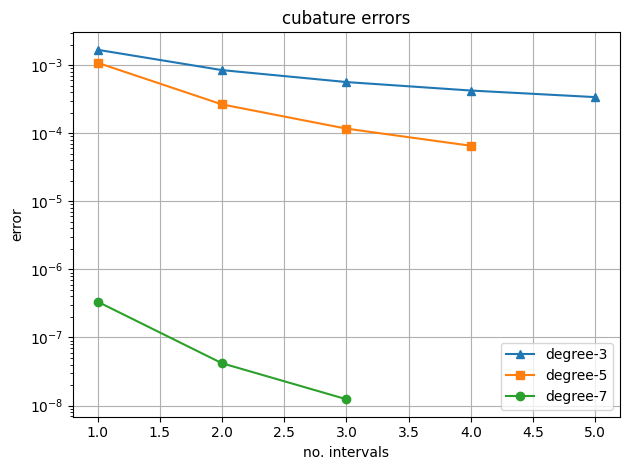

In [74]:
#cub_size_3 = 5 # made up sizes just to plot quickly
#cub_size_5 = 10
#cub_size_7 = 15

#cub_sim_3, cub_sim_5, cub_sim_7 = one_cub_sim(3, cub_size_3, d), one_cub_sim(5, cub_size_5, d), one_cub_sim(7, cub_size_7, d)
#w3, w5, w7 = jnp.ones(cub_size_3) / cub_size_3, jnp.ones(cub_size_5) / cub_size_5, jnp.ones(cub_size_7) / cub_size_7
importlib.reload(ut)
c3 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_3_correct, weights_3_correct, m) - true_mean)
c5 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_5, weights_5, m) - true_mean)
c7 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_7, weights_7, m) - true_mean)

ut.plot_functions([c3, c5, c7], [5, 4, 3], labels=["degree-3", "degree-5", "degree-7"], title="cubature errors",
                   xlabel="no. intervals", ylabel="error", scale="log") # also the ms would be changed from one formula to the next

TODO next:

- input cubature formulae for $d = 3$ and $N = 3, 5, 7$
- plot average over a few $A, B$'s instead of single choice
- compare speed of convergence with speed of convergence of MC